### Question 4: Backtesting
**Objective:** Demonstrate understanding of how to implement and backtest a trading strategy.
- Backtest either: RSI or MACD strategies.
- Show PnL, annualised sharpe ratio, and drawdown over time.
- Make your code as effieicent (vectorized) as possible.


**Backtesting the MACD strategy**

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [82]:
## reading, filtering and cleaning the data
data = pd.read_csv(r"C:\Users\lagan\Desktop\OilDesk-Intern-Assessment\data\MarketData.csv")
data.columns = ['Date','LME_Copper_3MO', 'LME_Aluminum_3MO', 'LME_Zinc_3MO','LME_Lead_3MO', 'LME_Tin_3MO', 'Generic_CL_Future']
data = data.drop(index = data.index[:6])
data['Date'] = pd.to_datetime(data['Date'],dayfirst = True)
## backtesting over two years 2020 & 2021
filtered_data = data[(data['Date'].dt.year >= 2020) & (data['Date'].dt.year <= 2021)][['Date', 'LME_Copper_3MO', 'LME_Zinc_3MO']]
filtered_data['LME_Copper_3MO'] = pd.to_numeric(filtered_data['LME_Copper_3MO'])
filtered_data['LME_Zinc_3MO'] = pd.to_numeric(filtered_data['LME_Zinc_3MO'])
filtered_data.head(20)

,Date,LME_Copper_3MO,LME_Zinc_3MO
2614,2020-01-01,6174.0,2272.0
2615,2020-01-02,6188.0,2310.0
2616,2020-01-03,6129.5,2306.0
2617,2020-01-06,6138.5,2324.5
2618,2020-01-07,6149.0,2346.0
2619,2020-01-08,6178.0,2403.0
2620,2020-01-09,6180.0,2377.0
2621,2020-01-10,6198.0,2378.0
2622,2020-01-13,6290.0,2378.0
2623,2020-01-14,6302.0,2373.5


In [83]:
## creating seperate df
copper_df = pd.DataFrame({
    'Date': filtered_data['Date'],
    'LME_Copper_3MO': filtered_data['LME_Copper_3MO']})
zinc_df = pd.DataFrame({
    'Date': filtered_data['Date'],
    'LME_Zinc_3MO': filtered_data['LME_Zinc_3MO']})

In [84]:
## function which applies the macd strat with additional pnl calcs
def apply_macd_strategy(df, price_column, initial_capital=1000):
    
    df['MACD'] = df[price_column].ewm(span=12).mean() - df[price_column].ewm(span=26).mean()
    df['Signal_Line'] = df['MACD'].ewm(span=9).mean()
    ## initial position = 0, all cash
    ## position == 1 when the strategy is holding the asset and 0 when not holding 
    df['Position'] = 0
    df['Position'] = np.where(df['MACD'] > df['Signal_Line'], 1, 0)  # Buy when MACD > Signal Line
    df['Position'] = df['Position'].shift(1).fillna(0)  # Shift to avoid lookahead bias
    
    df['Strategy_Return'] = df['Position'] * df[price_column].pct_change().fillna(0)
    df['Strategy_Cumulative'] = (1 + df['Strategy_Return']).cumprod()
    df['MACD_Portfolio_Value'] = initial_capital * df['Strategy_Cumulative']
    df['MACD_Daily_PnL'] = df['MACD_Portfolio_Value'].diff().fillna(0)
    df['MACD_Total_PnL'] = df['MACD_Daily_PnL'].cumsum()
    
    return df

In [85]:
apply_macd_strategy(copper_df, 'LME_Copper_3MO')

,Date,LME_Copper_3MO,MACD,Signal_Line,Position,Strategy_Return,Strategy_Cumulative,MACD_Portfolio_Value,MACD_Daily_PnL,MACD_Total_PnL
2614,2020-01-01,6174.0,0.000000,0.000000,0.0,0.000000,1.000000,1000.000000,0.000000,0.000000
2615,2020-01-02,6188.0,0.314103,0.174501,0.0,0.000000,1.000000,1000.000000,0.000000,0.000000
2616,2020-01-03,6129.5,-1.413852,-0.476463,1.0,-0.009454,0.990546,990.546218,-9.453782,-9.453782
2617,2020-01-06,6138.5,-1.840169,-0.938423,0.0,0.000000,0.990546,990.546218,0.000000,-9.453782
2618,2020-01-07,6149.0,-1.615263,-1.139768,0.0,0.000000,0.990546,990.546218,0.000000,-9.453782
...,...,...,...,...,...,...,...,...,...,...
3132,2021-12-27,9568.0,-2.500190,-20.259043,1.0,0.000000,1.444158,1444.158483,0.000000,444.158483
3133,2021-12-28,9568.0,0.815513,-16.044131,1.0,0.000000,1.444158,1444.158483,0.000000,444.158483
3134,2021-12-29,9680.5,12.378352,-10.359635,1.0,0.011758,1.461139,1461.138817,16.980333,461.138817
3135,2021-12-30,9691.5,22.173985,-3.852911,1.0,0.001136,1.462799,1462.799116,1.660299,462.799116


In [86]:
apply_macd_strategy(zinc_df, 'LME_Zinc_3MO')

,Date,LME_Zinc_3MO,MACD,Signal_Line,Position,Strategy_Return,Strategy_Cumulative,MACD_Portfolio_Value,MACD_Daily_PnL,MACD_Total_PnL
2614,2020-01-01,2272.0,0.000000,0.000000,0.0,0.000000,1.000000,1000.000000,0.000000,0.000000
2615,2020-01-02,2310.0,0.852564,0.473647,0.0,0.000000,1.000000,1000.000000,0.000000,0.000000
2616,2020-01-03,2306.0,0.962296,0.673913,1.0,-0.001732,0.998268,998.268398,-1.731602,-1.731602
2617,2020-01-06,2324.5,1.656556,1.006787,1.0,0.008023,1.006277,1006.277056,8.008658,6.277056
2618,2020-01-07,2346.0,2.854467,1.556430,1.0,0.009249,1.015584,1015.584416,9.307359,15.584416
...,...,...,...,...,...,...,...,...,...,...
3132,2021-12-27,3519.0,66.849430,41.187284,1.0,0.000000,1.151381,1151.380949,0.000000,151.380949
3133,2021-12-28,3519.0,69.361656,46.822159,1.0,0.000000,1.151381,1151.380949,0.000000,151.380949
3134,2021-12-29,3513.0,70.060845,51.469896,1.0,-0.001705,1.149418,1149.417810,-1.963139,149.417810
3135,2021-12-30,3532.5,71.365785,55.449074,1.0,0.005551,1.155798,1155.798012,6.380201,155.798012


In [94]:
## function which calculates the buy and hold strat metrics for comparison
def apply_buy_and_hold_strategy(df, price_column, initial_capital=1000):
    
    df['B&H_Return'] = df[price_column].pct_change().fillna(0)
    df['B&H_Cumulative'] = (1 + df['B&H_Return']).cumprod()
    df['B&H_Portfolio_Value'] = initial_capital * df['B&H_Cumulative']
    df['B&H_Daily_PnL'] = df['B&H_Portfolio_Value'].diff().fillna(0)
    df['B&H_Total_PnL'] = df['B&H_Daily_PnL'].cumsum()
    
    return df

In [88]:
apply_buy_and_hold_strategy(copper_df, 'LME_Copper_3MO', initial_capital=1000)
apply_buy_and_hold_strategy(zinc_df, 'LME_Zinc_3MO', initial_capital=1000)

,Date,LME_Zinc_3MO,MACD,Signal_Line,Position,Strategy_Return,Strategy_Cumulative,MACD_Portfolio_Value,MACD_Daily_PnL,MACD_Total_PnL,B&H_Return,B&H_Cumulative,B&H_Portfolio_Value,B&H_Daily_PnL,B&H_Total_PnL
2614,2020-01-01,2272.0,0.000000,0.000000,0.0,0.000000,1.000000,1000.000000,0.000000,0.000000,0.000000,1.000000,1000.000000,0.000000,0.000000
2615,2020-01-02,2310.0,0.852564,0.473647,0.0,0.000000,1.000000,1000.000000,0.000000,0.000000,0.016725,1.016725,1016.725352,16.725352,16.725352
2616,2020-01-03,2306.0,0.962296,0.673913,1.0,-0.001732,0.998268,998.268398,-1.731602,-1.731602,-0.001732,1.014965,1014.964789,-1.760563,14.964789
2617,2020-01-06,2324.5,1.656556,1.006787,1.0,0.008023,1.006277,1006.277056,8.008658,6.277056,0.008023,1.023107,1023.107394,8.142606,23.107394
2618,2020-01-07,2346.0,2.854467,1.556430,1.0,0.009249,1.015584,1015.584416,9.307359,15.584416,0.009249,1.032570,1032.570423,9.463028,32.570423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3132,2021-12-27,3519.0,66.849430,41.187284,1.0,0.000000,1.151381,1151.380949,0.000000,151.380949,0.000000,1.548856,1548.855634,0.000000,548.855634
3133,2021-12-28,3519.0,69.361656,46.822159,1.0,0.000000,1.151381,1151.380949,0.000000,151.380949,0.000000,1.548856,1548.855634,0.000000,548.855634
3134,2021-12-29,3513.0,70.060845,51.469896,1.0,-0.001705,1.149418,1149.417810,-1.963139,149.417810,-0.001705,1.546215,1546.214789,-2.640845,546.214789
3135,2021-12-30,3532.5,71.365785,55.449074,1.0,0.005551,1.155798,1155.798012,6.380201,155.798012,0.005551,1.554798,1554.797535,8.582746,554.797535


In [89]:
## functions that calculate risk metrics:  drawdown and sharpe ratio 
def calculate_drawdown(cumulative_returns):
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    return drawdown, max_drawdown

def annualized_sharpe_ratio(returns, risk_free_rate=0, periods_per_year=252):
    excess_returns = returns - risk_free_rate
    mean_return = excess_returns.mean()
    std_dev = excess_returns.std()
    sharpe_ratio = (mean_return / std_dev) * np.sqrt(periods_per_year)
    return sharpe_ratio

In [90]:
## backtests the macd strategy against a buy and hold strategy 
def backtest_macd_strategy(df, price_column, initial_capital=1000):
    
    df = apply_macd_strategy(df, price_column, initial_capital)
    df = apply_buy_and_hold_strategy(df, price_column, initial_capital)
    
    bh_sharpe = annualized_sharpe_ratio(df['B&H_Return'])
    macd_sharpe = annualized_sharpe_ratio(df['Strategy_Return'])

    bh_drawdown, bh_max_drawdown = calculate_drawdown(df['B&H_Cumulative'])
    macd_drawdown, macd_max_drawdown = calculate_drawdown(df['Strategy_Cumulative'])
    
    
    print(f"Buy-and-Hold {price_column} Strategy:")
    print(f"  Annualized Sharpe Ratio: {bh_sharpe:.2f}")
    print(f"  Max Drawdown: {bh_max_drawdown:.2%}")

    print(f"\nMACD {price_column} Strategy:")
    print(f"  Annualized Sharpe Ratio: {macd_sharpe:.2f}")
    print(f"  Max Drawdown: {macd_max_drawdown:.2%}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['B&H_Portfolio_Value'], label='Buy-and-Hold', linestyle='--')
    plt.plot(df['Date'], df['MACD_Portfolio_Value'], label='MACD Strategy')
    title = f"Strategy Performance Comparison: {price_column} (Monetary PnL)"
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], bh_drawdown, label='Buy-and-Hold Drawdown', linestyle='--')
    plt.plot(df['Date'], macd_drawdown, label='MACD Strategy Drawdown')
    plt.title(f"Drawdowns: {price_column}")
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    plt.legend()
    plt.grid(True)
    
    plt.show()
    

Buy-and-Hold LME_Copper_3MO Strategy:
  Annualized Sharpe Ratio: 1.10
  Max Drawdown: -26.53%

MACD LME_Copper_3MO Strategy:
  Annualized Sharpe Ratio: 1.29
  Max Drawdown: -9.67%


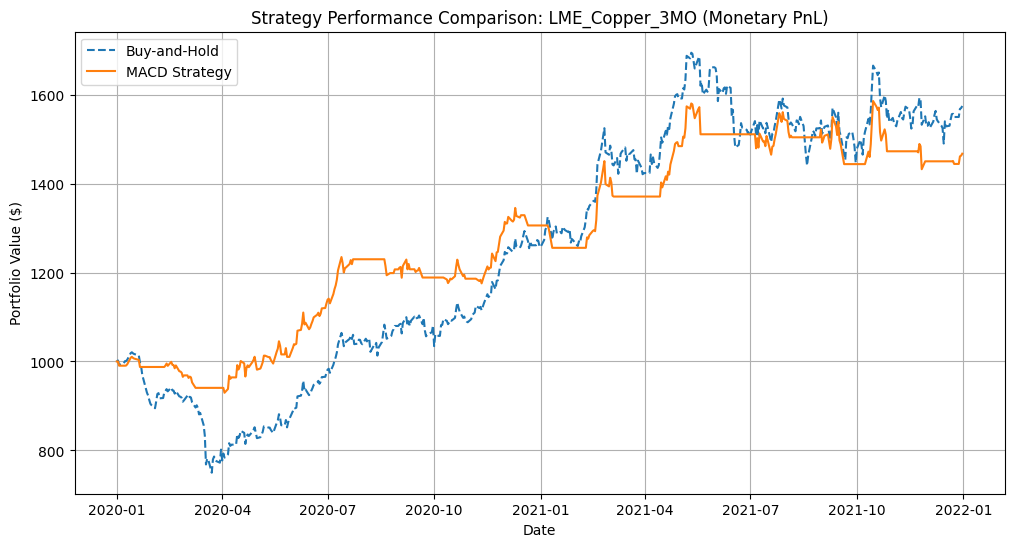

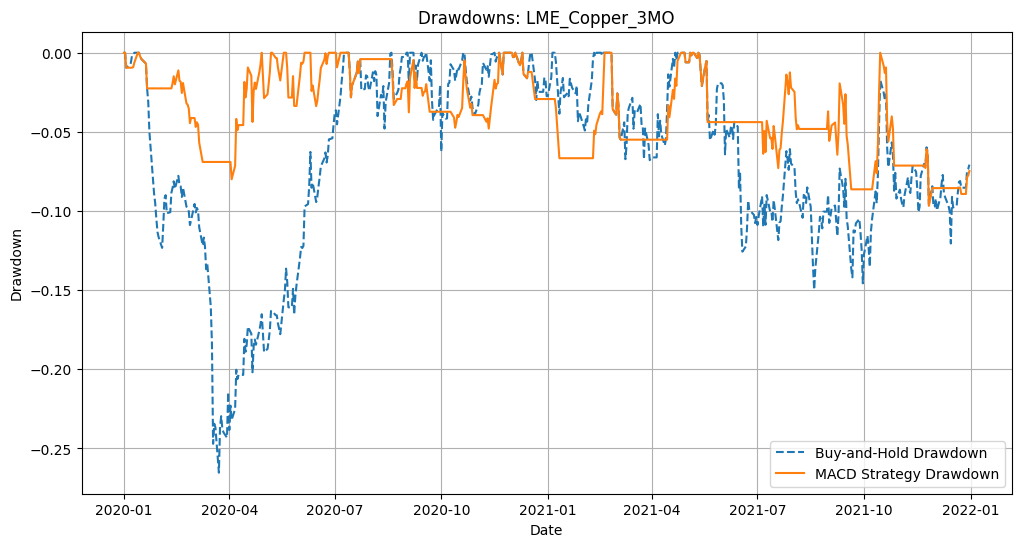

Buy-and-Hold LME_Zinc_3MO Strategy:
  Annualized Sharpe Ratio: 1.05
  Max Drawdown: -26.03%

MACD LME_Zinc_3MO Strategy:
  Annualized Sharpe Ratio: 0.50
  Max Drawdown: -16.48%


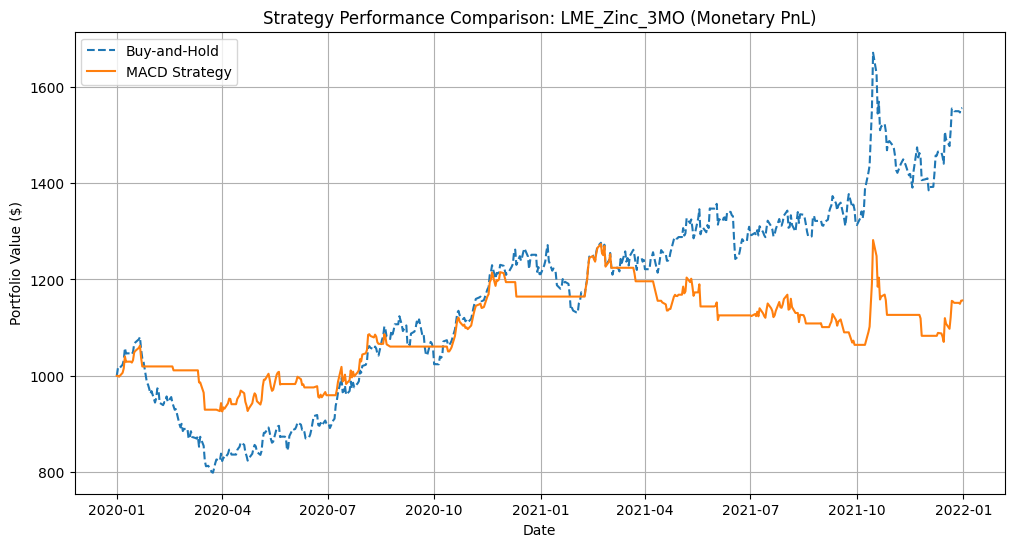

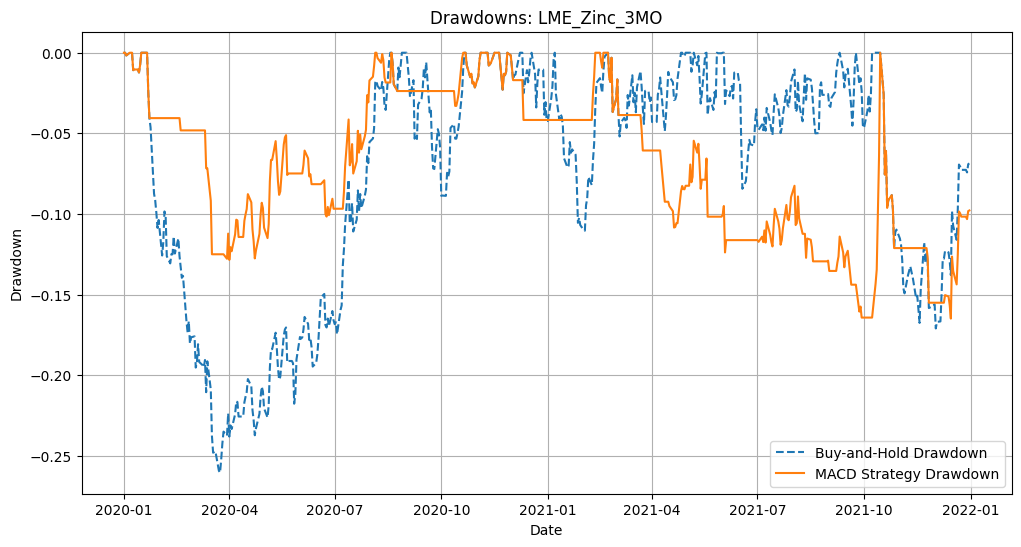

In [91]:
backtest_macd_strategy(copper_df,'LME_Copper_3MO')
backtest_macd_strategy(zinc_df,'LME_Zinc_3MO')

From these results over the two year period, we can see that for copper, the strategy improves upon the sharpe ratio, and results in significantly reduced drawdowns, whilst sacrificing a little profit. On a risk adjusted basis it seems like a good strategy.

For the zinc, teh strategy does reduced the max draw down but doesnt overall improve absolute returns or risk adjusted returns. The strategy significantly reduces the sharpe ratio. 

As from Q1, the settlement price of copper is more volatile than that of zinc historically, this could perhaps indicate that the MACD buy and sell strategy works better for more volatile assets